<a href="https://colab.research.google.com/github/takuminmin-m/hisseki_test_py/blob/main/hisseki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ランタイムの接続が切れないようにするJavaScriptコード
DevToolsのコンソールに入力

JavaScript code to stop for the runtime to disconnect 

```javascript
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click();
}
setInterval(KeepClicking,60000);
```



# データのインポート import data
google driveをマウント

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ライブラリの読み込みなど

Load libraries and more

In [6]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import os
import numpy as np
import IPython.display as display
import random
import matplotlib.pyplot as plt
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

作業ディレクトリの移動とデータの読み込み

Change the working directory and load labels.txt and handwriting images

/content/drive/MyDrive/colab/hisseki_test_py


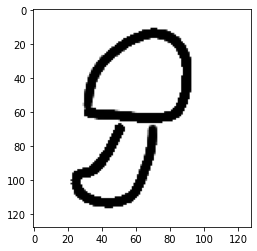

In [3]:
%cd /content/drive/MyDrive/colab/hisseki_test_py

def preprocess_image(image):
  image_4ch = tf.image.decode_image(image, channels=4, expand_animations=False)
  image_4ch = tf.image.resize(image_4ch, [128, 128])
  # image = tf.cast(tf.reduce_sum(image_4ch, 2, keepdims=True), tf.float32)
  # image /= 255.0  # normalize to [0,1] range
  image_4ch /= 255.0

  return image_4ch

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

label_file = open("tf_datas/labels.txt")
labels_str = label_file.readlines()
label_file.close()
label_int = list(map(lambda str: int(str), labels_str))

data_num = len(label_int)
image_paths = []
for i in range(data_num):
  image_paths.append("/content/drive/MyDrive/colab/hisseki_test_py/tf_datas/hisseki%d.png" % i)

path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_int, tf.int64))

# ランダムに画像をテスト表示
# randomly choose a handwriting image and show to test
plt.imshow(random.choice(list(image_ds)))
plt.grid(False)
plt.show()

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

教師データの前処理

Preprocess training data

In [4]:
BATCH_SIZE = 32

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=data_num))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


モデルの設定

Set model

In [8]:
model = keras.Sequential([
    layers.Conv2D(32, (7, 7), activation="relu", input_shape=(128, 128, 4)),
    layers.MaxPooling2D((4, 4)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(data_num, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 122, 122, 32)      6304      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

訓練

Train

In [9]:
model.fit(ds, epochs=10, steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 9s 770ms/step - loss: 4.1470 - accuracy: 0.1063
Epoch 2/10
10/10 [==============================] - 8s 779ms/step - loss: 1.7661 - accuracy: 0.5344
Epoch 3/10
10/10 [==============================] - 7s 750ms/step - loss: 0.5483 - accuracy: 0.8250
Epoch 4/10
10/10 [==============================] - 8s 764ms/step - loss: 0.2906 - accuracy: 0.8938
Epoch 5/10
10/10 [==============================] - 8s 753ms/step - loss: 0.1345 - accuracy: 0.9656
Epoch 6/10
10/10 [==============================] - 8s 772ms/step - loss: 0.0375 - accuracy: 0.9906
Epoch 7/10
10/10 [==============================] - 8s 762ms/step - loss: 0.0313 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 8s 769ms/step - loss: 0.0214 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 8s 751ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 7s 741ms/step - loss: 0.0108 - accuracy: 1.0000